## Set up

Install required packages and load relevant data. Ensure you adjust to add relevant classifiers.

In [48]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
# Add additional as required


# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns

### Set Directory paths

In [49]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

The `make_dataset.download_data` function retrieves the data directly from the kaggle API, unzips the files and saves them into the raw data directory.

In [50]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [51]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')


In [52]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [53]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Split into Training and Validation Set

In [69]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1,
                                                  random_state=42)

## Modelling

For this experiment, I will be ensembling a linear model and a random forest classifier.

## Linear Regression

In [70]:
lr_pipe = Pipeline([ ('scaler', StandardScaler()),
                 ('pca', PCA()),
        ('classifier',   LogisticRegression(max_iter = 10000))])
                    
lr_pipe.fit(X_train,y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('classifier', LogisticRegression(max_iter=10000))])

 class 1 :  684
 class 0 :  116
Confusion Matrix: 
 [[  2 114]
 [  1 683]]
Accuracy:  0.85625
AUC:  0.7273643879814478
              precision    recall  f1-score   support

           0       0.67      0.02      0.03       116
           1       0.86      1.00      0.92       684

    accuracy                           0.86       800
   macro avg       0.76      0.51      0.48       800
weighted avg       0.83      0.86      0.79       800



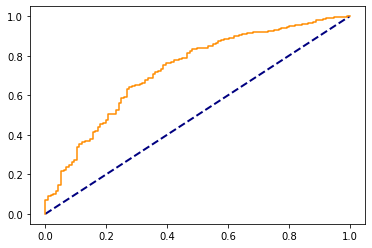

In [71]:
visualize.classification_reports(lr_pipe,X_val,y_val)

## Random Forest

In [72]:
rf_pipe = Pipeline([
        ('classifier', RandomForestClassifier(oob_score = True, n_estimators = 1000, max_depth = 3,max_features = 'log2',class_weight = 'balanced'))

])
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        max_features='log2', n_estimators=1000,
                                        oob_score=True))])

 class 1 :  684
 class 0 :  116
Confusion Matrix: 
 [[ 86  30]
 [239 445]]
Accuracy:  0.66375
AUC:  0.7232304900181488
              precision    recall  f1-score   support

           0       0.26      0.74      0.39       116
           1       0.94      0.65      0.77       684

    accuracy                           0.66       800
   macro avg       0.60      0.70      0.58       800
weighted avg       0.84      0.66      0.71       800



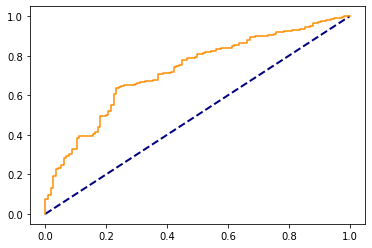

In [73]:
visualize.classification_reports(rf_pipe,X_val,y_val)

## Create Voting Classifier

In [74]:
rf_pipe = Pipeline([
        ('classifier', RandomForestClassifier(oob_score = True))
])


lr_pipe = Pipeline([ ('scaler', StandardScaler()),
                 ('pca', PCA()),
        ('classifier',   LogisticRegression(max_iter = 10000))
])


voter = VotingClassifier(estimators = [('rf',rf_pipe),('lr',lr_pipe)], voting = 'soft', weights = [3,1])

param_dist = {
    'lr__classifier__penalty': ['l2'],
    'rf__classifier__n_estimators': [1000],
    'rf__classifier__max_depth': [3],
    'rf__classifier__max_features': ['log2'],
    'rf__classifier__class_weight': ['balanced']
}

cv = RandomizedSearchCV(
    estimator=voter,
    param_distributions=param_dist,
    random_state=1,
    n_iter=1,
    cv=10,
    n_jobs=-1,
    verbose=10
)




In [75]:
cv.fit(X_train,y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


RandomizedSearchCV(cv=10,
                   estimator=VotingClassifier(estimators=[('rf',
                                                           Pipeline(steps=[('classifier',
                                                                            RandomForestClassifier(oob_score=True))])),
                                                          ('lr',
                                                           Pipeline(steps=[('scaler',
                                                                            StandardScaler()),
                                                                           ('pca',
                                                                            PCA()),
                                                                           ('classifier',
                                                                            LogisticRegression(max_iter=10000))]))],
                                              voting='soft', weights=[3, 1]),
 

### Inspect Results

 class 1 :  684
 class 0 :  116
Confusion Matrix: 
 [[ 52  64]
 [102 582]]
Accuracy:  0.7925
AUC:  0.7281583988707401
              precision    recall  f1-score   support

           0       0.34      0.45      0.39       116
           1       0.90      0.85      0.88       684

    accuracy                           0.79       800
   macro avg       0.62      0.65      0.63       800
weighted avg       0.82      0.79      0.80       800



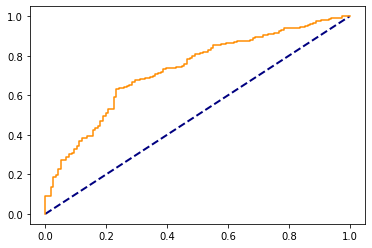

In [76]:
visualize.classification_reports(cv,X_val,y_val)

## Submit Predictions

In [15]:
submit_predictions.submit_predictions(cv, X_test, test_id,"12964298 week 1 submission")

Success! User is Authenticated


100%|██████████| 87.5k/87.5k [00:09<00:00, 9.11kB/s]


,id,TARGET_5Yrs
0,0,0.779642
1,1,0.782709
2,2,0.927070
3,3,0.939420
4,4,0.778216
...,...,...
3794,3794,0.932536
3795,3795,0.848801
3796,3796,0.749435
3797,3797,0.930695
